# Semantic Search for RAG Systems

This notebook implements and analyzes a semantic search engine for Retrieval-Augmented Generation (RAG) systems. It demonstrates document processing, multiple search strategies (similarity search, MMR, hybrid search), and comprehensive evaluation metrics.

In [1]:
!pip install -U numpy pandas sentence-transformers scikit-learn matplotlib seaborn langchain-community langchain-text-splitters langchain-chroma chromadb pypdf

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/e4/04/ff11611200acd602a1e5129e36cfd25bf01ad8e5cf927baf2e90236eb02e/numpy-2.3.4-cp311-cp311-macosx_14_0_arm64.whl.metadata
  Using cached numpy-2.3.4-cp311-cp311-macosx_14_0_arm64.whl.metadata (62 kB)
  Obtaining dependency information for sentence-transformers from https://files.pythonhosted.org/packages/bb/a6/a607a737dc1a00b7afe267b9bfde101b8cee2529e197e57471d23137d4e5/sentence_transformers-5.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/18/d6/ba863a4171ac9d7314c4d3fc251f015704a2caeee41ced89f321c049ed83/scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached scikit_learn-1.7.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.

## Document Processing and Vector Store Setup

We implement a complete pipeline for processing documents and creating a searchable vector store:

In [2]:
# --- Imports (LC split packages) ---
from pathlib import Path
import os
from typing import List

# LangChain loaders/splitters/embeddings/vector store
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# Utilities
from pprint import pprint

# --- Configuration ---
DATA_DIR = Path("data")                  # your PDF folder
PERSIST_DIR = "chroma_db"                # on-disk storage for Chroma (so it survives kernel restarts)
COLLECTION_NAME = "rag_docs_v1"          # name your collection (can change later)

# Chunking params (you can adjust later for experiments)
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

# Embedding model (fast + good for demos)
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"


/Users/zubair/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Discover and Load only PDFs
# --- Discover PDFs safely (ignore non-PDF files) ---
pdf_paths: List[Path] = []
if DATA_DIR.exists():
    for p in sorted(DATA_DIR.rglob("*")):   # recursive search
        if p.is_file() and p.suffix.lower() == ".pdf":
            pdf_paths.append(p)

print(f"Found {len(pdf_paths)} PDF(s) under {DATA_DIR.resolve()}.\n")
for p in pdf_paths[:10]:
    print("•", p)

# --- Load PDFs: produce a list of LangChain Documents (one per page) ---
all_docs = []
for pdf in pdf_paths:
    loader = PyPDFLoader(str(pdf))     # loads per-page by default
    docs = loader.load()
    # Attach a normalized 'source' field for later tracing
    for d in docs:
        d.metadata["source"] = str(pdf)
    all_docs.extend(docs)

print(f"\nLoaded {len(all_docs)} page-level Documents from {len(pdf_paths)} PDFs.")
if all_docs:
    print("Example document metadata:")
    pprint(all_docs[0].metadata)


Found 8 PDF(s) under /Users/zubair/Desktop/Columbia/Assignments/LLM/hw3/q2/data.

• data/01_ai_applications.pdf
• data/02_crispr_gene_editing.pdf
• data/03_climate_change_impacts.pdf
• data/04_olympic_games_history.pdf
• data/05_fiscal_policy_impacts.pdf
• data/06_silk_road_history.pdf
• data/07_renewable_energy_transition.pdf
• data/08_vaccines_history_impact.pdf

Loaded 17 page-level Documents from 8 PDFs.
Example document metadata:
{'author': 'Zubair Atha',
 'creationdate': "D:20251031002848Z00'00'",
 'creator': 'TextEdit',
 'moddate': "D:20251031002848Z00'00'",
 'page': 0,
 'page_label': '1',
 'producer': 'macOS Version 15.6 (Build 24G84) Quartz PDFContext',
 'source': 'data/01_ai_applications.pdf',
 'title': '01_ai_applications',
 'total_pages': 3}


In [4]:
# Split into Chunks with RecursiveCharacterTextSplitter
# --- Build the text splitter ---
splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    add_start_index=True  # <-- keeps 'metadata["start_index"]'
)

# --- Split all page docs into smaller chunks ---
chunked_docs = splitter.split_documents(all_docs)

# Add stable IDs for traceability (optional but handy)
for i, d in enumerate(chunked_docs):
    d.metadata["chunk_id"] = f"chunk-{i:06d}"

print(f"Created {len(chunked_docs)} chunks from {len(all_docs)} page-level docs.")
if chunked_docs:
    print("\nSample chunk preview:")
    sample = chunked_docs[0]
    print("Text (first 300 chars):", sample.page_content[:300].replace("\n"," ") + "...")
    print("Metadata:", sample.metadata)


Created 50 chunks from 17 page-level docs.

Sample chunk preview:
Text (first 300 chars): Semantic Search Dataset — Technology Title: Practical Applications of Artificial Intelligence in the Real  World Length target: ~900 words Artificial intelligence (AI) has moved from research labs into daily  life, weaving through sectors as varied as healthcare, finance,  logistics, education, crea...
Metadata: {'producer': 'macOS Version 15.6 (Build 24G84) Quartz PDFContext', 'creator': 'TextEdit', 'creationdate': "D:20251031002848Z00'00'", 'title': '01_ai_applications', 'author': 'Zubair Atha', 'moddate': "D:20251031002848Z00'00'", 'source': 'data/01_ai_applications.pdf', 'total_pages': 3, 'page': 0, 'page_label': '1', 'start_index': 0, 'chunk_id': 'chunk-000000'}


In [5]:
# --- Embedding function (cpu by default) ---
embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    # You can optionally set model_kwargs={"device": "cpu"}; it auto-selects CPU if no GPU.
)

print("Embedding model ready:", EMBEDDING_MODEL)

/var/folders/np/nf0l0rsx3wn2wmcw1dh1xrhc0000gn/T/ipykernel_15497/1260719526.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Embedding model ready: sentence-transformers/all-MiniLM-L6-v2


In [7]:
# Build a Chroma Vector Store with Metadata & Persist to Disk
# Build the vector store (persists automatically because persist_directory is set)
vectorstore = Chroma.from_documents(
    documents=chunked_docs,
    embedding=embeddings,
    persist_directory=PERSIST_DIR,   # this enables on-disk persistence
    collection_name=COLLECTION_NAME,
)

print(f"Chroma collection '{COLLECTION_NAME}' created at {PERSIST_DIR}.")


Chroma collection 'rag_docs_v1' created at chroma_db.


In [15]:
# --- Verify: count the items stored ---
# vectorstore.get() returns dict with 'ids', 'metadatas', etc. (be mindful with large collections)
summary = vectorstore.get(include=["metadatas"], limit=5)  # small sample
total_count = len(vectorstore.get(include=[]).get("ids", []))

print(f"Vector store now contains {total_count} items.")

# Show a few stored metadata rows to confirm fields like 'source', 'chunk_id', 'start_index'
print("\nSample stored metadatas (up to 5):")
for md in summary.get("metadatas", []):
    pprint(md)

# Optional: sanity mini-search just to demo end-to-end (no analysis yet)
if total_count > 0:
    query = "fiscal policy multipliers during recessions"
    res = vectorstore.similarity_search_with_score(query, k=3)
    print("\nMini demo search (k=2) for query:", query)
    for i, (doc, score) in enumerate(res, 1):
        print(f"\nResult {i} | Score: {score:.4f}")
        print("Source:", doc.metadata.get("source"))
        print("Chunk ID:", doc.metadata.get("chunk_id"))
        print("Start index:", doc.metadata.get("start_index"))
        print("Text preview:", doc.page_content[:200].replace("\n"," ") + "...")


Vector store now contains 100 items.

Sample stored metadatas (up to 5):
{'author': 'Zubair Atha',
 'chunk_id': 'chunk-000000',
 'creationdate': "D:20251031002848Z00'00'",
 'creator': 'TextEdit',
 'moddate': "D:20251031002848Z00'00'",
 'page': 0,
 'page_label': '1',
 'producer': 'macOS Version 15.6 (Build 24G84) Quartz PDFContext',
 'source': 'data/01_ai_applications.pdf',
 'start_index': 0,
 'title': '01_ai_applications',
 'total_pages': 3}
{'author': 'Zubair Atha',
 'chunk_id': 'chunk-000001',
 'creationdate': "D:20251031002848Z00'00'",
 'creator': 'TextEdit',
 'moddate': "D:20251031002848Z00'00'",
 'page': 0,
 'page_label': '1',
 'producer': 'macOS Version 15.6 (Build 24G84) Quartz PDFContext',
 'source': 'data/01_ai_applications.pdf',
 'start_index': 827,
 'title': '01_ai_applications',
 'total_pages': 3}
{'author': 'Zubair Atha',
 'chunk_id': 'chunk-000002',
 'creationdate': "D:20251031002848Z00'00'",
 'creator': 'TextEdit',
 'moddate': "D:20251031002848Z00'00'",
 'page': 0,
 'pag

In [10]:
# 1) How many items are actually in the vector store?
store_snapshot = vectorstore.get(include=[], limit=1_000_000)  # adjust high if needed
n_items = len(store_snapshot.get("ids", []))
print("Total items in vector store:", n_items)

# 2) How many *distinct* text chunks?
store_docs = vectorstore.get(include=["documents", "metadatas"], limit=10_000)
docs_list = store_docs.get("documents", []) or []
metas_list = store_docs.get("metadatas", []) or []

unique_texts = len(set([d.strip() for d in docs_list if isinstance(d, str)]))
print("Distinct text chunks (by exact string):", unique_texts)

# 3) How many chunks are basically empty? (likely from scanned PDFs)
empty_like = [d for d in docs_list if not isinstance(d, str) or len(d.strip()) < 100]
print("Very short/empty chunks (<100 chars):", len(empty_like))

# 4) Peek a bit at sources to see if only one file contributed most content
from collections import Counter
sources = [ (m or {}).get("source", "unknown") for m in metas_list ]
print("Top sources by chunk count:")
for src, cnt in Counter(sources).most_common(10):
    print(f"{cnt:4d}  {src}")


Total items in vector store: 100
Distinct text chunks (by exact string): 50
Very short/empty chunks (<100 chars): 0
Top sources by chunk count:
  18  data/01_ai_applications.pdf
  12  data/02_crispr_gene_editing.pdf
  12  data/03_climate_change_impacts.pdf
  12  data/04_olympic_games_history.pdf
  12  data/05_fiscal_policy_impacts.pdf
  12  data/07_renewable_energy_transition.pdf
  12  data/08_vaccines_history_impact.pdf
  10  data/06_silk_road_history.pdf


In [13]:
QUERIES = [
    # Core coverage
    "artificial intelligence applications in industry",
    "CRISPR delivery challenges and off-target effects",
    "climate change impacts on extreme weather",
    "history of the Olympic Games ancient to modern",
    "fiscal policy multipliers during recessions",
    "trade and cultural exchange along the Silk Road",
    "renewable energy transition bottlenecks in grids",
    "public health impact of vaccines over time",

    # Diversity / nuance (great for MMR vs similarity)
    "Olympics broadcasting and commercialization vs athlete experience",
    "climate adaptation vs mitigation strategies in cities",
    "renewables: storage needs vs transmission expansion",
    "CRISPR: base editing vs prime editing differences",
    "vaccines: herd immunity and equity considerations",
    "Silk Road: Buddhism spread vs material trade goods",

    # Short / keyword-ish
    "AI in healthcare",
    "green hydrogen challenges",
    "automatic stabilizers examples",
    "marine heatwaves fisheries",
]
print(f"Loaded {len(QUERIES)} test queries.")


Loaded 18 test queries.


## Semantic Search Implementation

We implement multiple search methods: similarity search, MMR search, and hybrid search.


In [16]:
# If you've already created `vectorstore`, this cell is harmless.
# Otherwise, it reopens the persisted Chroma collection from disk.

from pathlib import Path
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

PERSIST_DIR = "chroma_db"
COLLECTION_NAME = "rag_docs_v1"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# Reuse existing 'vectorstore' if present
try:
    vectorstore
except NameError:
    vectorstore = None

if vectorstore is None:
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
    vectorstore = Chroma(
        embedding_function=embeddings,
        persist_directory=PERSIST_DIR,
        collection_name=COLLECTION_NAME,
    )

print("Vector store ready.")


Vector store ready.


In [17]:
from typing import List, Tuple
from collections import Counter
from pprint import pprint

def print_results(title: str, results: List, show_scores: bool = False):
    """
    Pretty-print a small list of retrieval results (LangChain Documents, or (Document, score) tuples).
    Shows source file, chunk id, start index, and a short preview.
    """
    print(f"\n=== {title} ===")
    if not results:
        print("(no results)")
        return

    docs_only = []
    for i, r in enumerate(results, 1):
        if show_scores:
            doc, score = r
        else:
            doc, score = r, None

        docs_only.append(doc)

        src = doc.metadata.get("source", "N/A")
        cid = doc.metadata.get("chunk_id", "N/A")
        start = doc.metadata.get("start_index", "N/A")
        preview = doc.page_content[:200].replace("\n", " ") + ("..." if len(doc.page_content) > 200 else "")

        if score is not None:
            print(f"\n[{i}] Score: {score:.4f}")
        else:
            print(f"\n[{i}]")
        print(f"Source: {src}")
        print(f"Chunk ID: {cid} | Start index: {start}")
        print(f"Preview: {preview}")

    # Simple diversity proxy: how many unique sources in the top-k?
    sources = [d.metadata.get("source", "N/A") for d in docs_only]
    src_counts = Counter(sources)
    print("\nUnique sources in results:", len(src_counts), "| Top sources:", dict(src_counts.most_common(3)))


In [18]:
# Implements vector_store.similarity_search() with adjustable k.
# Returns a list[Document].
def run_similarity(query: str, k: int = 5):
    return vectorstore.similarity_search(query, k=k)


In [19]:
# Implements vector_store.similarity_search_with_score().
# Returns a list[(Document, score)] where "score" is a distance/sim value provided by the backend.
def run_similarity_with_score(query: str, k: int = 5):
    return vectorstore.similarity_search_with_score(query, k=k)


In [20]:
# Implements vector_store.max_marginal_relevance_search().
# MMR balances relevance and diversity. We set lambda_mult = 0.5 as required.
# Returns a list[Document].
def run_mmr(query: str, k: int = 5, fetch_k: int = 20, lambda_mult: float = 0.5):
    """
    k:       number of results to return
    fetch_k: initial candidate pool size to consider for MMR selection
    lambda_mult: λ in the MMR formula
    """
    return vectorstore.max_marginal_relevance_search(
        query=query,
        k=k,
        fetch_k=fetch_k,
        lambda_mult=lambda_mult,
    )


In [23]:
# Pick any query you like; or use one from the QUERIES list you created earlier.
query = "renewable energy transition bottlenecks in grids"
k = 5

# a) Plain similarity
sim_results = run_similarity(query, k=k)
print_results(f"Similarity Search (k={k})", sim_results, show_scores=False)

# b) Similarity WITH scores (lower score = better match)
sim_with_scores = run_similarity_with_score(query, k=k)
print_results(f"Similarity Search WITH scores (k={k})", sim_with_scores, show_scores=True)

# c) MMR search (λ=0.5)
mmr_results = run_mmr(query, k=k, fetch_k=20, lambda_mult=0.5)
print_results(f"MMR Search (k={k}, λ=0.5)", mmr_results, show_scores=False)



=== Similarity Search (k=5) ===

[1]
Source: data/07_renewable_energy_transition.pdf
Chunk ID: chunk-000039 | Start index: 856
Preview: electronics and grid management. Storage—particularly battery systems— helps match variable generation with demand, while flexible resources  (hydro, demand response, interconnections) balance the sys...

[2]
Source: data/07_renewable_energy_transition.pdf
Chunk ID: chunk-000039 | Start index: 856
Preview: electronics and grid management. Storage—particularly battery systems— helps match variable generation with demand, while flexible resources  (hydro, demand response, interconnections) balance the sys...

[3]
Source: data/07_renewable_energy_transition.pdf
Chunk ID: chunk-000040 | Start index: 1660
Preview: projects face delays and curtailment. Meanwhile, variability across  regions persists: some markets deploy renewables rapidly, while others  face financing constraints or policy uncertainty that slows...

[4]
Source: data/07_renewable_energy_tran

In [24]:
# 7) Batch demo over multiple queries (runs similarity vs MMR side-by-side)
# - Uses QUERIES if you already defined it; otherwise defines a default set.
# - Prints a brief summary for each (unique sources is a quick diversity proxy).

try:
    QUERIES
except NameError:
    QUERIES = [
        "artificial intelligence applications in industry",
        "CRISPR delivery challenges and off-target effects",
        "climate change impacts on extreme weather",
        "history of the Olympic Games ancient to modern",
        "fiscal policy multipliers during recessions",
    ]

k = 5

for q in QUERIES:
    print("\n" + "=" * 100)
    print(f"Query: {q}")
    print("=" * 100)

    # Similarity (no scores)
    sim_res = vectorstore.similarity_search(q, k=k)
    print_results(f"Similarity (k={k})", sim_res, show_scores=False)

    # Similarity WITH scores (distance; lower is better in Chroma)
    sim_scored = vectorstore.similarity_search_with_score(q, k=k)
    print_results(f"Similarity WITH scores (k={k})", sim_scored, show_scores=True)

    # MMR (λ = 0.5)
    mmr_res = vectorstore.max_marginal_relevance_search(q, k=k, fetch_k=20, lambda_mult=0.5)
    print_results(f"MMR (k={k}, λ=0.5)", mmr_res, show_scores=False)



Query: artificial intelligence applications in industry

=== Similarity (k=5) ===

[1]
Source: data/01_ai_applications.pdf
Chunk ID: chunk-000008 | Start index: 0
Preview: References and suggested reading (for context and further  exploration): • Wikipedia, “Applications of artificial intelligence.” • Case studies from healthcare imaging triage and financial fraud  dete...

[2]
Source: data/01_ai_applications.pdf
Chunk ID: chunk-000008 | Start index: 0
Preview: References and suggested reading (for context and further  exploration): • Wikipedia, “Applications of artificial intelligence.” • Case studies from healthcare imaging triage and financial fraud  dete...

[3]
Source: data/01_ai_applications.pdf
Chunk ID: chunk-000000 | Start index: 0
Preview: Semantic Search Dataset — Technology Title: Practical Applications of Artificial Intelligence in the Real  World Length target: ~900 words Artificial intelligence (AI) has moved from research labs int...

[4]
Source: data/01_ai_application

## Evaluation and Analysis

We evaluate the implementation with comprehensive metrics and visualizations.


In [25]:
# --- Evaluation configuration ---
CHUNK_SIZES = [500, 1000, 1500]
CHUNK_OVERLAP = 200
KS = [1, 5, 10]

# Methods to evaluate
METHODS = ["similarity", "similarity_with_score", "mmr"]
MMR_LAMBDA = 0.5
MMR_FETCH_K = 20

DATA_DIR = "data"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

# Use your existing QUERIES list from earlier, or define a fallback
try:
    QUERIES
except NameError:
    QUERIES = [
        "artificial intelligence applications in industry",
        "CRISPR delivery challenges and off-target effects",
        "climate change impacts on extreme weather",
        "history of the Olympic Games ancient to modern",
        "fiscal policy multipliers during recessions",
        "trade and cultural exchange along the Silk Road",
        "renewable energy transition bottlenecks in grids",
        "public health impact of vaccines over time",
    ]

print(f"Evaluating on {len(QUERIES)} queries, chunk sizes {CHUNK_SIZES}, ks {KS}, methods {METHODS}.")


Evaluating on 18 queries, chunk sizes [500, 1000, 1500], ks [1, 5, 10], methods ['similarity', 'similarity_with_score', 'mmr'].


In [26]:
from pathlib import Path
from typing import List
from pprint import pprint

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

def build_store_for_chunk_size(chunk_size: int, overlap: int = 200,
                               collection_prefix: str = "rag_eval") -> Chroma:
    """
    Loads only PDFs from DATA_DIR, splits with RecursiveCharacterTextSplitter,
    embeds (HuggingFace), and returns a Chroma vector store persisted to disk.
    Each chunk size gets its own collection to keep results separate.
    """
    # 1) discover & load PDFs
    pdfs: List[Path] = [p for p in Path(DATA_DIR).rglob("*.pdf") if p.is_file()]
    if not pdfs:
        raise FileNotFoundError(f"No PDFs found under {DATA_DIR}")

    all_docs = []
    for pdf in sorted(pdfs):
        docs = PyPDFLoader(str(pdf)).load()
        for d in docs:
            d.metadata["source"] = str(pdf)
        all_docs.extend(docs)

    # 2) split into chunks
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        add_start_index=True
    )
    chunks = splitter.split_documents(all_docs)
    for i, d in enumerate(chunks):
        d.metadata["chunk_id"] = f"c{chunk_size}-{i:06d}"

    # 3) embedding + chroma
    embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
    persist_dir = f"chroma_db_{chunk_size}"
    collection_name = f"{collection_prefix}_{chunk_size}"

    vs = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=persist_dir,
        collection_name=collection_name,
    )
    print(f"[build] chunk_size={chunk_size}: {len(chunks)} chunks → collection '{collection_name}' @ {persist_dir}")

    return vs


In [27]:
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# We'll reuse the same embedding model to compute diversity on retrieved chunks
_embed_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

def compute_diversity_metrics(docs):
    """
    Returns:
      - unique_sources: number of distinct 'source' fields in the top-k set
      - mean_pairwise_sim: average pairwise cosine similarity among retrieved chunks (higher = more redundant)
      - max_pairwise_sim: maximum pairwise similarity (1.0 means two chunks are near-identical)
    """
    if not docs:
        return dict(unique_sources=0, mean_pairwise_sim=np.nan, max_pairwise_sim=np.nan)

    sources = [d.metadata.get("source", "N/A") for d in docs]
    unique_sources = len(set(sources))

    # Embed retrieved documents' texts (short k ⇒ cheap)
    texts = [d.page_content for d in docs]
    embs = _embed_model.embed_documents(texts)  # shape: (k, dim)
    embs = np.array(embs)
    if len(embs) < 2:
        return dict(unique_sources=unique_sources, mean_pairwise_sim=np.nan, max_pairwise_sim=np.nan)

    S = cosine_similarity(embs)  # k x k
    # consider only upper triangle (i<j)
    triu_vals = S[np.triu_indices_from(S, k=1)]
    return dict(
        unique_sources=unique_sources,
        mean_pairwise_sim=float(np.mean(triu_vals)),
        max_pairwise_sim=float(np.max(triu_vals)),
    )

def timed_search(vectorstore: Chroma, method: str, query: str, k: int, lambda_mult=0.5, fetch_k=20):
    """
    Runs one search call and returns (results_docs, elapsed_ms).
    For similarity_with_score, we convert to docs for uniform diversity metrics.
    """
    t0 = time.perf_counter()
    if method == "similarity":
        res = vectorstore.similarity_search(query, k=k)
        elapsed = (time.perf_counter() - t0) * 1000
        return res, elapsed
    elif method == "similarity_with_score":
        res_scored = vectorstore.similarity_search_with_score(query, k=k)  # list of (doc, distance)
        elapsed = (time.perf_counter() - t0) * 1000
        docs = [d for (d, _score) in res_scored]
        return docs, elapsed
    elif method == "mmr":
        res = vectorstore.max_marginal_relevance_search(
            query=query, k=k, fetch_k=fetch_k, lambda_mult=lambda_mult
        )
        elapsed = (time.perf_counter() - t0) * 1000
        return res, elapsed
    else:
        raise ValueError(f"Unknown method: {method}")


In [28]:
import pandas as pd

all_results = []

for chunk_size in CHUNK_SIZES:
    print(f"\n=== Building index for chunk_size={chunk_size} ===")
    vs = build_store_for_chunk_size(chunk_size, overlap=CHUNK_OVERLAP, collection_prefix="rag_eval")

    # For each query, for each method, for each k
    for q in QUERIES:
        for method in METHODS:
            for k in KS:
                docs, elapsed_ms = timed_search(
                    vs, method=method, query=q, k=k,
                    lambda_mult=MMR_LAMBDA, fetch_k=MMR_FETCH_K
                )
                div = compute_diversity_metrics(docs)
                all_results.append({
                    "chunk_size": chunk_size,
                    "method": method,
                    "k": k,
                    "query": q,
                    "latency_ms": elapsed_ms,
                    "unique_sources": div["unique_sources"],
                    "mean_pairwise_sim": div["mean_pairwise_sim"],
                    "max_pairwise_sim": div["max_pairwise_sim"],
                    "num_results": len(docs),
                })

df = pd.DataFrame(all_results)
print(f"\nCollected {len(df)} rows.")
df.head()



=== Building index for chunk_size=500 ===
[build] chunk_size=500: 114 chunks → collection 'rag_eval_500' @ chroma_db_500

=== Building index for chunk_size=1000 ===
[build] chunk_size=1000: 50 chunks → collection 'rag_eval_1000' @ chroma_db_1000

=== Building index for chunk_size=1500 ===
[build] chunk_size=1500: 34 chunks → collection 'rag_eval_1500' @ chroma_db_1500

Collected 486 rows.


,chunk_size,method,k,query,latency_ms,unique_sources,mean_pairwise_sim,max_pairwise_sim,num_results
0,500,similarity,1,artificial intelligence applications in industry,9.722292,1,NaN,NaN,1
1,500,similarity,5,artificial intelligence applications in industry,7.210792,1,0.504981,0.592875,5
2,500,similarity,10,artificial intelligence applications in industry,7.763542,2,0.380102,0.659942,10
3,500,similarity_with_score,1,artificial intelligence applications in industry,7.566125,1,NaN,NaN,1
4,500,similarity_with_score,5,artificial intelligence applications in industry,7.771292,1,0.504981,0.592875,5


In [29]:
# Average metrics grouped for compact reporting
summary = (
    df.groupby(["chunk_size", "method", "k"])
      .agg(
          avg_latency_ms=("latency_ms", "mean"),
          avg_unique_sources=("unique_sources", "mean"),
          avg_mean_pairwise_sim=("mean_pairwise_sim", "mean"),
          avg_max_pairwise_sim=("max_pairwise_sim", "mean"),
          avg_num_results=("num_results", "mean")
      )
      .reset_index()
      .sort_values(["chunk_size", "method", "k"])
)

print("=== Summary (averages) ===")
summary


=== Summary (averages) ===


,chunk_size,method,k,avg_latency_ms,avg_unique_sources,avg_mean_pairwise_sim,avg_max_pairwise_sim,avg_num_results
0,500,mmr,1,8.350296,1.000000,NaN,NaN,1.0
1,500,mmr,5,8.008590,2.666667,0.329819,0.578681,5.0
2,500,mmr,10,8.396201,3.333333,0.380026,0.708172,10.0
3,500,similarity,1,7.599745,1.000000,NaN,NaN,1.0
4,500,similarity,5,7.180347,1.222222,0.577351,0.746282,5.0
5,500,similarity,10,7.365192,1.666667,0.505065,0.797372,10.0
6,500,similarity_with_score,1,7.184711,1.000000,NaN,NaN,1.0
7,500,similarity_with_score,5,6.933426,1.222222,0.577351,0.746282,5.0
8,500,similarity_with_score,10,7.173891,1.666667,0.505065,0.797372,10.0
9,1000,mmr,1,9.206130,1.000000,NaN,NaN,1.0


In [30]:
# Compare MMR vs similarity for unique_sources for each (chunk_size, query, k)
mmr = df[df["method"] == "mmr"]
sim = df[df["method"] == "similarity"]

merged = pd.merge(
    mmr, sim,
    on=["chunk_size", "query", "k"],
    suffixes=("_mmr", "_sim")
)

wins = merged[merged["unique_sources_mmr"] > merged["unique_sources_sim"]].copy()
wins = wins.sort_values(["chunk_size", "k", "query"])
print(f"MMR showed better coverage on {len(wins)} (chunk_size, query, k) cases.")
wins[[
    "chunk_size", "k", "query",
    "unique_sources_mmr", "unique_sources_sim",
    "avg_mmr_latency_ms"
]].rename(columns={"avg_mmr_latency_ms":"latency_note"}) if "avg_mmr_latency_ms" in wins.columns else wins


MMR showed better coverage on 102 (chunk_size, query, k) cases.


,chunk_size,method_mmr,k,query,latency_ms_mmr,unique_sources_mmr,mean_pairwise_sim_mmr,max_pairwise_sim_mmr,num_results_mmr,method_sim,latency_ms_sim,unique_sources_sim,mean_pairwise_sim_sim,max_pairwise_sim_sim,num_results_sim
43,500,mmr,5,AI in healthcare,6.737542,3,0.248827,0.470231,5,similarity,6.983417,1,0.471958,0.555136,5
4,500,mmr,5,CRISPR delivery challenges and off-target effects,9.317708,3,0.359162,0.631263,5,similarity,10.860334,1,0.728078,0.847818,5
34,500,mmr,5,CRISPR: base editing vs prime editing differences,7.944750,2,0.286188,0.622800,5,similarity,6.725833,1,0.693933,0.847818,5
25,500,mmr,5,Olympics broadcasting and commercialization vs...,10.036209,3,0.245147,0.549148,5,similarity,7.221291,1,0.663218,0.797248,5
40,500,mmr,5,Silk Road: Buddhism spread vs material trade g...,8.238292,3,0.266081,0.682126,5,similarity,7.280542,1,0.593283,0.790295,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,1500,mmr,10,public health impact of vaccines over time,5.870416,6,0.268834,0.710705,10,similarity,5.216125,4,0.382051,0.857796,10
128,1500,mmr,10,renewable energy transition bottlenecks in grids,6.289333,6,0.297637,0.768718,10,similarity,5.885917,3,0.458998,0.781150,10
140,1500,mmr,10,renewables: storage needs vs transmission expa...,6.129000,7,0.201521,0.646162,10,similarity,5.261500,3,0.464367,0.781978,10
125,1500,mmr,10,trade and cultural exchange along the Silk Road,6.082750,7,0.175038,0.784647,10,similarity,5.545542,5,0.242865,0.784647,10


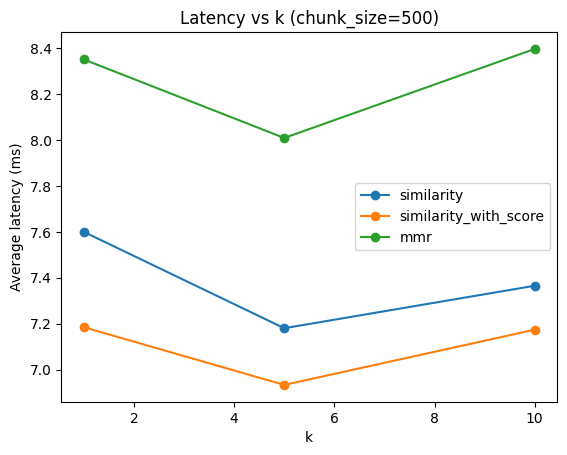

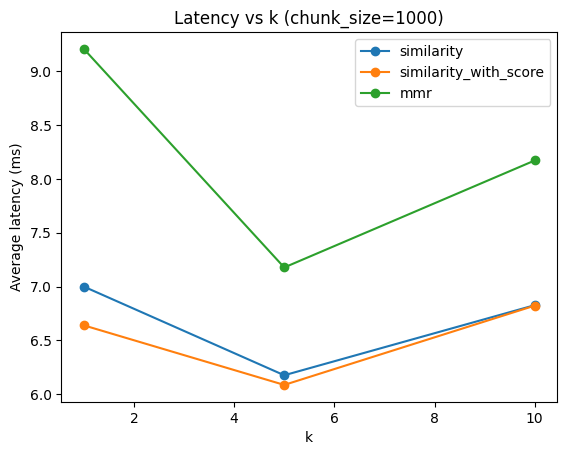

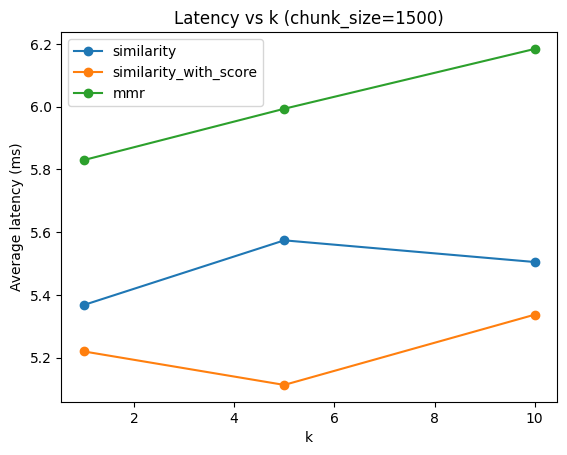

In [31]:
import matplotlib.pyplot as plt

# One figure per chunk size
for cs in CHUNK_SIZES:
    fig = plt.figure()
    sub = summary[summary["chunk_size"] == cs]
    for method in METHODS:
        line = sub[sub["method"] == method]
        plt.plot(line["k"], line["avg_latency_ms"], marker="o", label=method)
    plt.title(f"Latency vs k (chunk_size={cs})")
    plt.xlabel("k")
    plt.ylabel("Average latency (ms)")
    plt.legend()
    plt.show()


[build] chunk_size=1000: 50 chunks → collection 'rag_vis_1000' @ chroma_db_1000


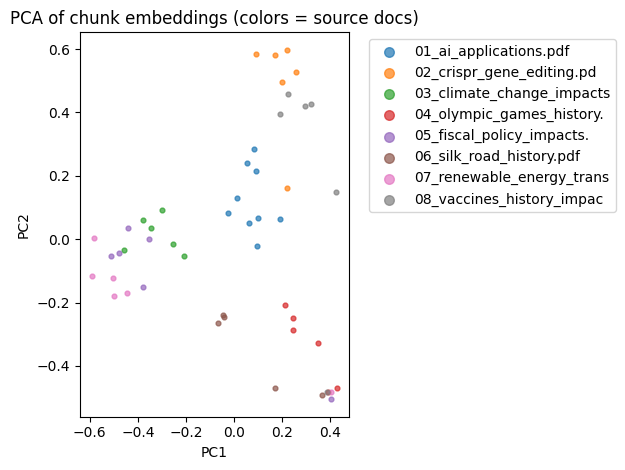

In [32]:
# Visualize structure of the index (a sample) via PCA to 2D.
# Colors by source document to illustrate clusters.
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def plot_embedding_pca(vectorstore: Chroma, sample_size: int = 800):
    # Get embeddings & metadata from the store (sample if large)
    store = vectorstore.get(include=["embeddings", "metadatas"])
    embs = np.array(store["embeddings"])
    mds = store["metadatas"]
    n = len(embs)
    if n == 0:
        print("No embeddings to visualize.")
        return

    idx = np.arange(n)
    if n > sample_size:
        rng = np.random.default_rng(42)
        idx = rng.choice(n, size=sample_size, replace=False)
    E = embs[idx]
    M = [mds[i] for i in idx]
    sources = [m.get("source", "N/A") for m in M]

    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(E)

    # Map sources to small palette
    uniq = list(dict.fromkeys(sources))  # preserve order
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    color_map = {s: next(color_cycle) for s in uniq}

    plt.figure()
    for s in uniq:
        mask = [src == s for src in sources]
        pts = Z[mask]
        plt.scatter(pts[:,0], pts[:,1], s=12, alpha=0.7, label=Path(s).name[:25] if s!="N/A" else "N/A")
    plt.title("PCA of chunk embeddings (colors = source docs)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Choose a chunk size to visualize (e.g., 1000)
vs_vis = build_store_for_chunk_size(1000, overlap=CHUNK_OVERLAP, collection_prefix="rag_vis")
plot_embedding_pca(vs_vis, sample_size=800)


In [33]:
# Which chunk size gave fastest average latency (by method)?
display(
    summary.sort_values("avg_latency_ms").groupby("method").first()[["avg_latency_ms"]]
)

# Which chunk size had best diversity (lower mean pairwise sim & more unique sources)?
display(
    summary.sort_values(["avg_mean_pairwise_sim", "avg_unique_sources"],
                        ascending=[True, False]).groupby("method").first()[["avg_mean_pairwise_sim","avg_unique_sources"]]
)


,avg_latency_ms
method,
mmr,5.829468
similarity,5.367574
similarity_with_score,5.112771


,avg_mean_pairwise_sim,avg_unique_sources
method,,
mmr,0.164684,4.222222
similarity,0.345570,4.000000
similarity_with_score,0.345570,4.000000


In [36]:
import os
from fpdf import FPDF

# --- Configuration ---
input_folder = "data_new"
output_folder = "data_new_pdfs"
font_file = "data_new/dejavu-lgc-fonts-ttf-2.37/ttf/DejaVuLGCSans.ttf" # <-- Font file must be in the same directory
# ---------------------

def convert_txt_to_pdf(input_dir, output_dir, font_path):
    """
    Converts all .txt files in the input_dir to PDF files in the output_dir
    using a Unicode-compatible font.
    """
    
    # 1. Check if the input directory exists
    if not os.path.isdir(input_dir):
        print(f"Error: Input folder '{input_dir}' not found.")
        return
        
    # 2. Check if the font file exists
    if not os.path.exists(font_path):
        print(f"Error: Font file '{font_path}' not found.")
        print("Please download DejaVuSans.ttf and place it in the same folder as this script.")
        return

    # 3. Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output will be saved to: {output_dir}")

    # 4. Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".txt"):
            
            txt_filepath = os.path.join(input_dir, filename)
            pdf_filename = os.path.splitext(filename)[0] + ".pdf"
            pdf_filepath = os.path.join(output_dir, pdf_filename)

            try:
                # 5. Create a PDF object
                pdf = FPDF()
                pdf.add_page()
                
                # --- THIS IS THE FIX ---
                # 6. Add the Unicode font. 'uni=True' enables UTF-8.
                pdf.add_font('DejaVu', '', font_path, uni=True)
                pdf.set_font('DejaVu', size=12)
                # -----------------------
                
                # 7. Read the text file content
                with open(txt_filepath, "r", encoding="utf-8") as f:
                    text_content = f.read()

                # 8. Add the text to the PDF
                # 'text=text_content' is the updated parameter name (replaces 'txt=')
                pdf.multi_cell(0, 7, text=text_content)
                
                # 9. Save the PDF file
                pdf.output(pdf_filepath)
                
                print(f"Successfully converted: {filename}  ->  {pdf_filename}")

            except Exception as e:
                print(f"Error converting {filename}: {e}")

    print("\nConversion complete.")

# --- Run the conversion ---
if __name__ == "__main__":
    convert_txt_to_pdf(input_folder, output_folder, font_file)

Output will be saved to: data_new_pdfs
Successfully converted: 06_crispr-delivery.txt  ->  06_crispr-delivery.pdf
Successfully converted: 18_automatic-stabilizers.txt  ->  18_automatic-stabilizers.pdf
Successfully converted: 07_vaccine-history.txt  ->  07_vaccine-history.pdf
Successfully converted: 17_fiscal-multipliers.txt  ->  17_fiscal-multipliers.pdf


/var/folders/np/nf0l0rsx3wn2wmcw1dh1xrhc0000gn/T/ipykernel_15497/909148708.py:46: DeprecationWarning: "uni" parameter is deprecated since v2.5.1 and will be removed in a future release
  pdf.add_font('DejaVu', '', font_path, uni=True)


Successfully converted: 04_edge-AI-IoT.txt  ->  04_edge-AI-IoT.pdf
Successfully converted: 20_industrial-evolution.txt  ->  20_industrial-evolution.pdf
Successfully converted: 13-olympics.txt  ->  13-olympics.pdf
Successfully converted: 08_vaccine-coldchain.txt  ->  08_vaccine-coldchain.pdf
Successfully converted: 12_marine-heatwaves.txt  ->  12_marine-heatwaves.pdf
Successfully converted: 19_carbon-pricing.txt  ->  19_carbon-pricing.pdf
Successfully converted: 05-crispr-basics.txt  ->  05-crispr-basics.pdf
Successfully converted: 14_paralympic-evolution.txt  ->  14_paralympic-evolution.pdf
Successfully converted: 11_grid-batteries.txt  ->  11_grid-batteries.pdf
Successfully converted: 03_search-and-rag.txt  ->  03_search-and-rag.pdf
Successfully converted: 02_recommender-systems.txt  ->  02_recommender-systems.pdf
Successfully converted: 15_broadcasting-and-commercialization.txt  ->  15_broadcasting-and-commercialization.pdf
Successfully converted: 09_extreme-weather.txt  ->  09_extre